In [1]:
!pip install transformers torch pandas accelerate quanto flash_attn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from transformers import pipeline
import torch
import pandas as pd
import glob
import csv
import re
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

2024-04-22 09:05:15.958632: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 09:05:16.000918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dfs = []

def read_file(file):
    try:
        return open(directory+file+".txt", "r").read()
    except:
        return None

for info_file in glob.glob("RusLit/**/info.csv", recursive=True):
    try:
        directory = info_file[:-8]
        info = pd.read_csv(info_file)
        info["author"] = directory.split("/")[2]
        info["type"] = directory.split("/")[1]
        info["text"] = info["name"].map(read_file)
        dfs.append(info)
    except:
        pass

df = pd.concat(dfs, ignore_index=True).dropna()
df["year"] = df["year"].astype(str).map(lambda x: x.split("-")[0].split(".")[0]).astype(int)
df_small = df[df["text"].str.len() < 16384].copy()

In [4]:
pipe = pipeline("text-generation", model="cognitivecomputations/dolphin-2.9-llama3-8b", model_kwargs={"torch_dtype": torch.bfloat16, "attn_implementation": "flash_attention_2"}, device_map="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
generated_genres = pipe(df_small["text"].map(lambda x: x + "List all potential genres in a comma seperated list:").to_list(), max_new_tokens=20)
df_small["genres"] = [re.sub(r'[^a-z ,]', '', generated_genre[0]["generated_text"].split("List all potential genres in a comma seperated list:")[-1].strip().lower()).split(", ") for generated_genre in generated_genres]

In [6]:
df_small_explode = df_small.explode('genres')
df_small_explode = df_small_explode[df_small_explode['genres'] != ""]
genre_trends = df_small_explode.groupby(['year', 'genres']).size().unstack(fill_value=0)
filtered_genre_trends = genre_trends[genre_trends.sum().sort_values()[-10:].index]
percentage_filtered_genre_trends = filtered_genre_trends.divide(filtered_genre_trends.sum(axis=1), axis=0) * 100
percentage_filtered_genre_trends.dropna()
percentage_filtered_genre_trends = percentage_filtered_genre_trends.reset_index()
melted_percentage_filtered_genre_trends = percentage_filtered_genre_trends.melt(id_vars='year', var_name='genre', value_name='popularity')

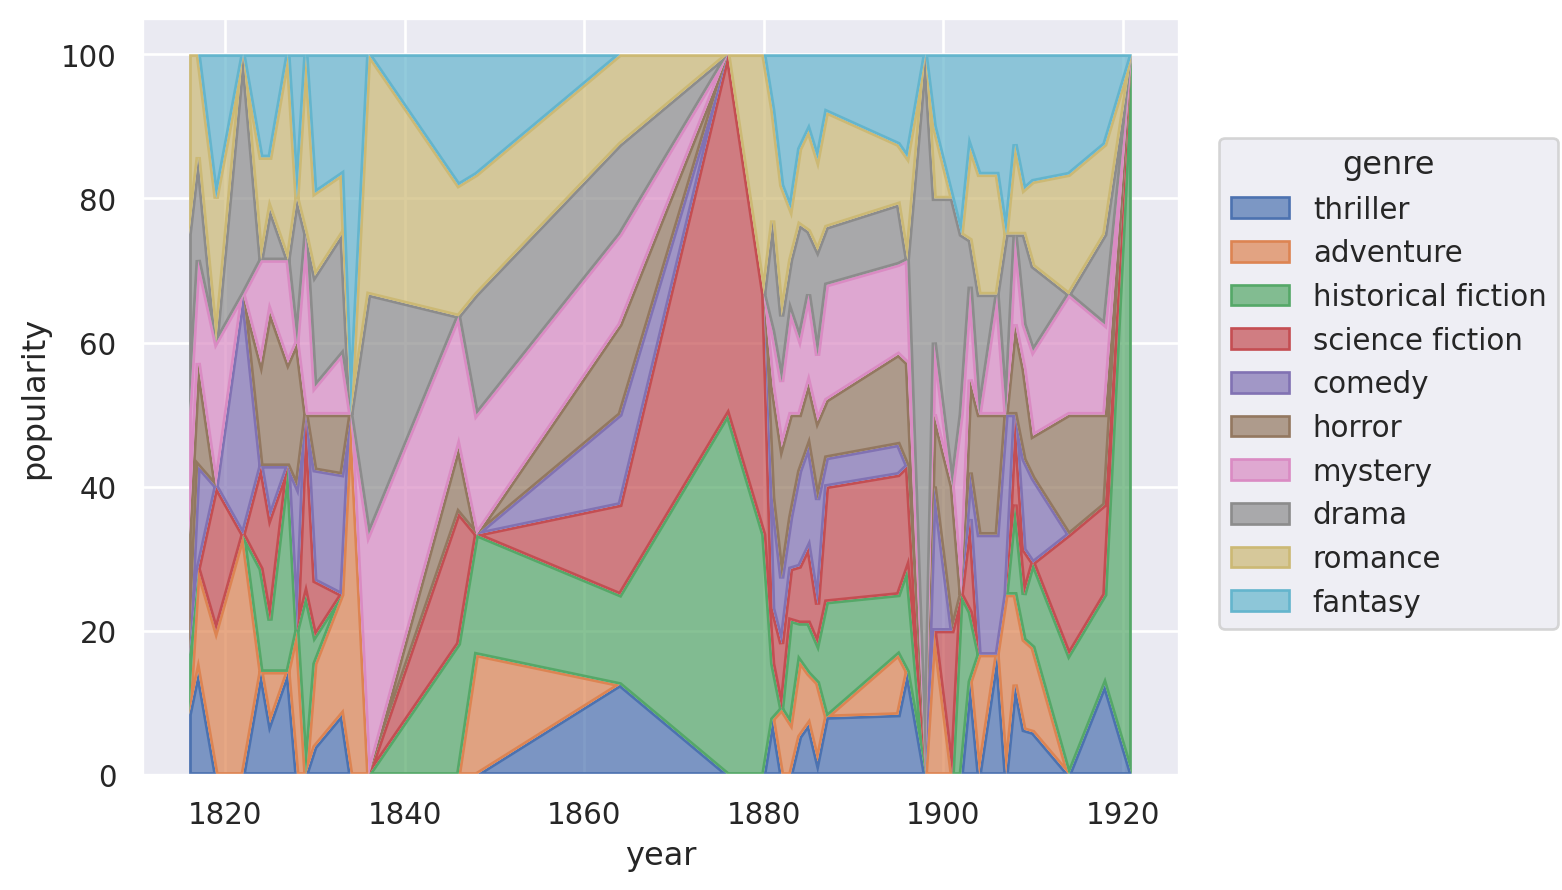

In [7]:
so.Plot(melted_percentage_filtered_genre_trends, "year", "popularity", color="genre").add(so.Area(alpha=.7), so.Stack())